# 2D Schrodinger Equation with Coulomb Potential

In [7]:
# Import the FEMSystem Class from directory above
import sys
sys.path.append('..')
from FEMSystem import FEMSystem

# Remaining Imports
import jax.numpy as jnp
import skfem as fem
from jaxopt import LBFGS

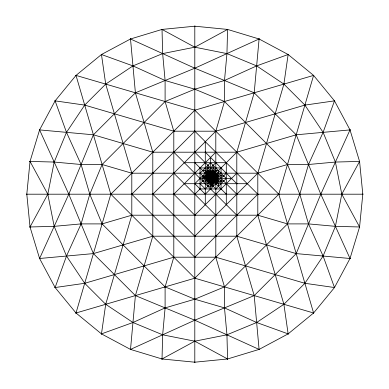

In [20]:
center = (1,1)
centerX,centerY = center

def create_refined_mesh(radius=10.0, initial_refs=3, refine_steps=5, refine_radius=1.0):
    """
    Creates a circular mesh with heavy refinement at the origin to handle
    the Coulomb singularity.
    """
    # 1. Initialize a standard circle
    mesh = fem.MeshTri.init_circle(nrefs=initial_refs)
    
    # Scale the mesh to the desired physical domain size
    # init_circle creates a unit circle, so we multiply nodes by radius
    mesh = mesh.scaled(radius)

    # 2. Iteratively refine elements near the origin
    for _ in range(refine_steps):
        # Calculate the centroid of every element
        # mesh.p are points, mesh.t are triangles (topology)
        x_centers = mesh.p[0, mesh.t].mean(axis=0)
        y_centers = mesh.p[1, mesh.t].mean(axis=0)
        
        # Calculate distance from origin
        dist = jnp.sqrt((x_centers-centerX)**2 + (y_centers-centerY)**2)
        
        # Identify elements within the refinement radius
        # We shrink the refinement radius slightly each pass to concentrate nodes at 0
        elements_to_refine = jnp.nonzero(dist < refine_radius)[0]
        
        if len(elements_to_refine) > 0:
            mesh = mesh.refined(elements_to_refine)
            refine_radius *= 0.7 # Focus in tighter on the next loop
            
    return mesh

# Generate the mesh
mesh = create_refined_mesh()

# Quick visual check (if you use matplotlib)
mesh.draw().show()

In [21]:
# Step 1: Define FEM System
element = fem.ElementTriP1()
intorder = 3
femsystem = FEMSystem(mesh,element,intorder)

# Step 2: Define Objective, in terms of u_interior
def v(x_vec):
    x,y = x_vec[0],x_vec[1]
    epsilon = 1e-6
    return 1 / jnp.sqrt((x-centerX)**2 + (y-centerY)**2 + epsilon)

def ke(u,grad_u,x):
    return jnp.sum(grad_u ** 2, axis=0)

def pe(u,grad_u,x):
    return v(x) * u**2

def objective(u_interior):
    u_global = femsystem.apply_bc_and_norm(u_interior)
    ke_int = femsystem.integrate(ke,u_global)
    pe_int = femsystem.integrate(pe,u_global)
    return ke_int - pe_int

# Step 3: Run Minimization Loop
u_init_interior = jnp.ones(len(femsystem.interior_dofs))
print("\nStarting Optimization...")
# Use JAX's BFGS optimizer
solver = LBFGS(fun=objective,tol=1e-10,verbose=True)
result = solver.run(u_init_interior)
result = result.params # The interior points


Starting Optimization...
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 0.05915481969714165 Objective Value:-0.06695123016834259  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 0.05643901601433754 Objective Value:-0.17228730022907257  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 0.026927003636956215 Objective Value:-0.21873962879180908  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 0.0227438323199749 Objective Value:-0.24195356667041779  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 0.04227716848254204 Objective Value:-0.26558738946914673  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 0.043513406068086624 Objective Value:-0.30135226249694824  Stepsize:1.

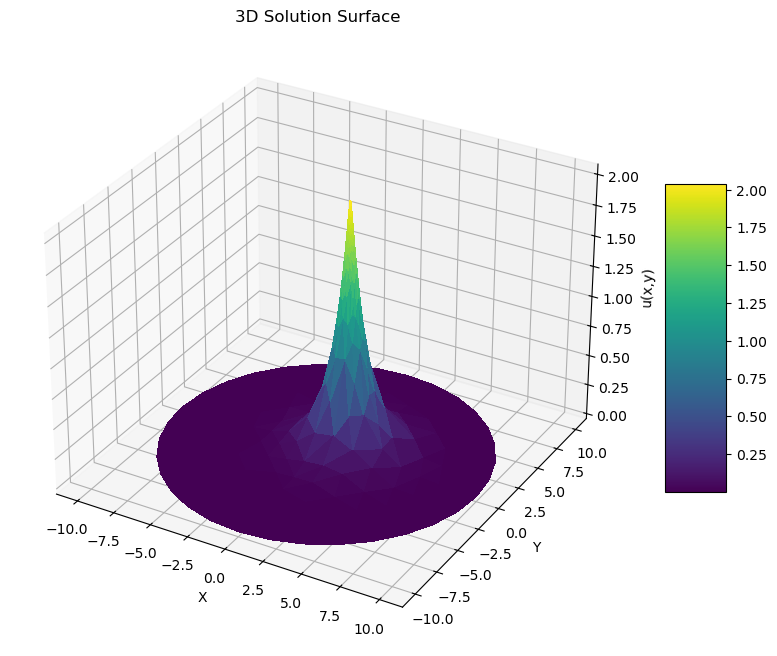

In [22]:
femsystem.plot_at_interior_2d_in3d(result,plot_title="U1")